# 7.3 使用内置的训练和评估循环

别吐槽这一节的译名,原文直译就是这个.

---

已经提到了,keras api 是复杂度逐渐披露,但是无论是新手还是专家,调用的 api 是一样的.

模型训练也是这样,我们已经熟悉了简单模型训练/拟合/评估/预测的流程.


In [1]:
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [2]:
from tensorflow.keras.datasets import mnist
#取数据
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

In [3]:
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28, ))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model


model = get_mnist_model()  #模型


In [4]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])  #模型参数
model.fit(train_images,
          train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))  #训练

Epoch 1/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2986 - accuracy: 0.9121 - val_loss: 0.1466 - val_accuracy: 0.9576
Epoch 2/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1680 - accuracy: 0.9518 - val_loss: 0.1218 - val_accuracy: 0.9667
Epoch 3/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1384 - accuracy: 0.9625 - val_loss: 0.1161 - val_accuracy: 0.9722


In [5]:
test_metrics = model.evaluate(test_images, test_labels)  #评估

313/313 [==============================] - 1s 3ms/step - loss: 0.1054 - accuracy: 0.9725


In [6]:
predictions = model.predict(test_images)  #预测

上面就是新手级别的工作流示例了.应该已经非常熟悉了.

要定制这个工作流有几种办法

- 使用完全自定义的指标
- 给 `fit` 传递回调,以安排训练时特定时间点执行的任务

下面小节都会看到


## 编写自定义指标

指标是衡量模型性能的关键,特别是衡量模型在训练数据和在测试数据上差异的关键.

常见指标已经内置在 keras,成为了 `keras.metrics` 的一部分.但是如果你想做一些不寻常的事,此时会需要自定义指标.


In [7]:
import tensorflow as tf


class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(name="total_samples",
                                             initializer="zeros",
                                             dtype="int32")

    def update_state(self,
                     y_true,
                     y_pred,
                     sample_weight=None):  #可以忽略 sample_weight ,这个例子不使用
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(
            tf.square(y_true -
                      y_pred))  # (真实值-预测值) square 取平方 reduce_sum 压缩求和(未细究)
        self.mse_sum.assign_add(mse)  # assign_add 求和;;全部 mse 之和
        num_samples = tf.shape(y_pred)[0]  #样本数量
        self.total_samples.assign_add(num_samples)  #全部样本数量

    def result(self):  #计算
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_states(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)


与自定义 layer / model 类似

- 需要继承 `keras.metrics.Metric`
- 指标内部变量值的更新要在 `update_state` 编写,不能像 layer 那样通过反向传播计算.

上面是平均误差根值(RMSE Root Mean Squared Error)


题外话 方差 标准差(SD) 均方差 均方误差(MSE) 均方根误差(RMSE)

---

描述 **一个随机变量** 取值与 **均值** 的偏离程度

- 方差: 所有 (值 - 均值)平方之和,再 * 概率.
- 标准差: $\sqrt{方差}$,相比方差更加直观,读图直接出概率.
- **标准差 == 均方差**

描述一组数据种, **各个数据** 与 **真实值** 的偏离程度

- 均方误差(MSE): 与方差计算很像.最核心的插值换成了 (预测值 - 实际值)
- 均方根误差(RMSE): $\sqrt{均方误差}$,和标准差很像.常用于机器学习模型的评价.

`result` 返回真正的 RMSE (来自 rmse 定义)

`reset_states` 重置指标,在进行另一轮评估时使用.


In [8]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])  #自定义指标
model.fit(train_images,
          train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1558/1563 [============================>.] - ETA: 0s - loss: 0.2943 - accuracy: 0.9134 - rmse: 7.1826

c:\Users\stati\Git\Deep-Learning\tf\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric RootMeanSquaredError implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


1563/1563 [==============================] - 8s 5ms/step - loss: 0.2939 - accuracy: 0.9134 - rmse: 7.1825 - val_loss: 0.1593 - val_accuracy: 0.9536 - val_rmse: 7.3613
Epoch 2/3
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1625 - accuracy: 0.9538 - rmse: 7.3566 - val_loss: 0.1205 - val_accuracy: 0.9679 - val_rmse: 7.4081
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.1076 - accuracy: 0.9721 - rmse: 7.4376


使用自定义指标和使用内置指标完全相同(还记得 `"accuracy"` 最终会被展开成相关对象吗?)

在结果中,看到了自定义的指标 `rmse`


## 使用回调

迄今为止我们使用 `model.fit` 就像是一个只有发动机的火箭,一点火就飞,至于飞行的结果是中途爆炸还是到达目的地再爆炸,我们完全不知道,除非发射一次.发射一次我们有了数据,就再发射一枚新的火箭,轰炸目标,boom!

这样没什么问题,就是成本太高.大型数据集训练需要耗费非常多的资源.更好的做法是安上飞控,当偏离目标时能导航,不明原因失败时能记录.给 `fit` 传递的回调就是做这件事情的.

回调是一个对象而不是函数(实现特定方法的实例),它可以在训练的特定时刻被调用.模型的一切都可以被回调修改.模型状态不错,保存一下,基础操作;模型训练效果不佳,换个学习率吧,没问题;

下面是回调的被使用的典型时刻

- 模型的检查点: 训练资源很珍贵,存个档.
- 过早停止: 验证损失不再有改善时,可以选择终止训练保存模型.
- 动态调整模型某些值: 优化器的学习率,典型的.
- 记录训练和验证的指标: 这个我们已经用过了,实际上是回调.


```py
keras.callbacks.ModelCheckpoint
keras.callbacks.EarlyStopping
keras.callbacks.LearningRateScheduler
keras.callbacks.ReduceLROnPlateau
keras.callbacks.CSVLogger
```

上面是 `keras.callbacks` 包含的一些回调(不是全部).


In [9]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="accuracy", #监控 accuracy 指标
        patience=1, # 经历 1 轮指标没有改善
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",  #监视 val_loss
        save_best_only=True,  #只保存 val_loss 最好的模型
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [18]:
model.fit(train_images,
          train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0884 - accuracy: 0.9794 - val_loss: 0.1181 - val_accuracy: 0.9778
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0878 - accuracy: 0.9799 - val_loss: 0.1166 - val_accuracy: 0.9800
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0910 - accuracy: 0.9807 - val_loss: 0.1188 - val_accuracy: 0.9785
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0840 - accuracy: 0.9818 - val_loss: 0.1284 - val_accuracy: 0.9786
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0795 - accuracy: 0.9825 - val_loss: 0.1283 - val_accuracy: 0.9795
Epoch 6/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.0805 - accuracy: 0.9828 - val_loss: 0.1275 - val_accuracy: 0.9792
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.0774 - accuracy: 0.9840 - val_loss: 0.1346 - val_accuracy:

上面的停止,是连续调用了几轮才有的.默认 10 次直接调用,确实会有没有触发 EarlyStopping 的情况.

上面是使用 EarlyStopping 和 ModelCheckpoint 的例子.实例化一个 callbacks_list 列表,成员是需要使用的 `keras.callbacks` 下的对象.在 `fit` 传入给 callbacks 参数.

EarlyStopping 是在监控指标经过一定次数还没有改善时,终止训练.这个回调允许模型在过拟合后终止训练,通常配合 ModelCheckpoint 使用,后者允许保存在训练阶段持续保存模型,当然也能设置只保存在监视指标上表现最好的模型.


In [11]:
# model.save('my_checkpoint_path')
# model = keras.models.load_model("checkpoint_path.keras")

当然手动保存模型也是可以的,调用 `model.save` 传入保存的路径.

加载模型时调用 `keras.models.load_model` 从指定路径加载.


### 编写自定义回调

虽然 keras 内置的回调能覆盖很多场景,但是不能猜测用户需求,keras 可以从头写一个回调.


所谓实现自定义回调,就是继承 `keras.callbacks.Callback`,需要在那个时刻调用,就实现下面的某个方法.

```py
on_epoch_begin(epoch, logs) # epoch开始前
on_epoch_end(epoch, logs) # epoch结束后
on_batch_begin(batch, logs) # batch开始前
on_batch_end(batch, logs)# batch结束后
on_train_begin(logs)# 训练开始前
on_train_end(logs)# 训练结束后
```

参数

- logs 是字典,记录的是是上一个 epoch/batch/train 的信息(训练和验证指标等).
- batch/epoch 整数,记录的是当前的轮次


In [12]:
from matplotlib import pyplot as plt


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):  #训练开始前调用
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):  # batch 结束后
        self.per_batch_losses.append(logs.get("loss"))  #添加损失数据

    def on_epoch_end(self, epoch, logs):  # epoch 结束后
        plt.clf()  #开始绘图
        plt.plot(range(len(self.per_batch_losses)),
                 self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

`LossHistory` 是简单的自定义回调示例,记录每次 epoch 中每轮 loss 的变化,epoch 结束后绘图.


Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2967 - accuracy: 0.9128 - val_loss: 0.1457 - val_accuracy: 0.9575
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1677 - accuracy: 0.9533 - val_loss: 0.1220 - val_accuracy: 0.9658
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.1408 - accuracy: 0.9618 - val_loss: 0.1175 - val_accuracy: 0.9712
Epoch 4/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1258 - accuracy: 0.9675 - val_loss: 0.1115 - val_accuracy: 0.9728
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1138 - accuracy: 0.9707 - val_loss: 0.1109 - val_accuracy: 0.9747
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1123 - accuracy: 0.9725 - val_loss: 0.1093 - val_accuracy: 0.9755
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1044 - accuracy: 0.9744 - val_loss: 0.1104 - val_accuracy:

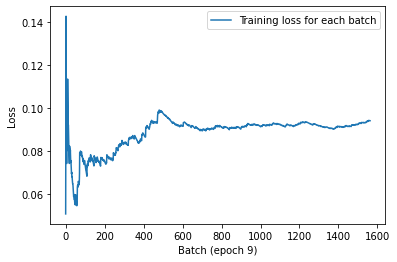

In [17]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images,
          train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

第 0 轮次
![plot_at_epoch_0](plot_at_epoch_0.png)

第 3 轮次
![plot_at_epoch_3](plot_at_epoch_3.png)


## TensorBoard 可视化

为了开发更好的模型,我们需要获得丰富的频繁的反馈.想法->模型->结果->想法...的迭代过程.keras 可以帮助我们尽快从想法到模型,gpu 可以帮助我们从模型到结果.那么从结果再到想法呢? 这是 TensorBoard 的作用了,可视化模型训练的结果及一切.

![the_loop_of_progress](the_loop_of_progress.png)


TensorBoard 是基于 web 的应用程序,几乎是监控训练时模型内部变化最好的工具.

- 训练期间直观监测指标
- 可视化模型结构
- 可视化激活和梯度的变化
- 3D 可视化

[TensorBoard](https://www.tensorflow.org/tensorboard) 官方教程(有中文)


In [19]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

tensorboard = keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_log_dir", )
model.fit(train_images,
          train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.2963 - accuracy: 0.9132 - val_loss: 0.1504 - val_accuracy: 0.9562
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1666 - accuracy: 0.9542 - val_loss: 0.1220 - val_accuracy: 0.9670
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1389 - accuracy: 0.9626 - val_loss: 0.1156 - val_accuracy: 0.9715
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1278 - accuracy: 0.9670 - val_loss: 0.1153 - val_accuracy: 0.9722
Epoch 5/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1167 - accuracy: 0.9707 - val_loss: 0.1063 - val_accuracy: 0.9756
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.1088 - accuracy: 0.9729 - val_loss: 0.1090 - val_accuracy: 0.9743
Epoch 7/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.1056 - accuracy: 0.9749 - val_loss: 0.1120 - val_accuracy:

最简单使用 tensorboard 的方式就是调用 `keras.callbacks.TensorBoard` 将结果保存在你保存日志的地方.

终端运行 `tensorboard --logdir /full_path_to_your_log_dir` 会启动一个本地服务,返回地址.浏览器打开 url.


In [21]:
%load_ext tensorboard
%tensorboard --logdir /full_path_to_your_log_dir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11992), started 0:11:42 ago. (Use '!kill 11992' to kill it.)

jupyter 中使用,上面的代码,会在页面中插入 html 的结果.
